In [1]:
!git clone https://github.com/bamsumit/slayerPytorch.git

Cloning into 'slayerPytorch'...
remote: Enumerating objects: 3271, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 3271 (delta 126), reused 234 (delta 116), pack-reused 3012
Receiving objects: 100% (3271/3271), 87.46 MiB | 32.33 MiB/s, done.
Resolving deltas: 100% (1180/1180), done.
Updating files: 100% (1435/1435), done.


In [2]:
%cd /content/slayerPytorch

/content/slayerPytorch


In [3]:
!python setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [4]:
%cd test

/content/slayerPytorch/test


In [5]:
!python -m unittest

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
.................................
----------------------------------------------------------------------
Ran 33 tests in 11.961s

OK


In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import slayerSNN as snn
from slayerSNN import loihi as spikeLayer
from slayerSNN import quantize as quantizeParams
from slayerSNN import learningStats as learningStats
from slayerSNN import optimizer as optimizer

In [8]:


netParams = snn.params('/content/slayerPytorch/example/01_Oxford/oxford/oxford.yaml')

Ts   = netParams['simulation']['Ts']
Ns   = int(netParams['simulation']['tSample'] / netParams['simulation']['Ts'])
Nin  = int(netParams['layer'][0]['dim'])
Nhid = int(netParams['layer'][1]['dim'])
Nout = int(netParams['layer'][2]['dim'])



In [9]:
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = spikeLayer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.fc1   = slayer.dense(Nin, Nhid)
        self.fc2   = slayer.dense(Nhid, Nout)

    def forward(self, spikeInput):
        spike = self.slayer.spikeLoihi(self.fc1(spikeInput))
        spike = self.slayer.delayShift(spike, 1)
        # A minimum axonal delay of 1 tick is required in Loihi hardare
        spike = self.slayer.spikeLoihi(self.fc2(spike))
        spike = self.slayer.delayShift(spike, 1)
        return spike

In [10]:


def genLoihiParams(net):
    fc1Weights = quantizeParams.apply(net.fc1.weight, 2).flatten().cpu().data.numpy()
    fc2Weights = quantizeParams.apply(net.fc2.weight, 2).flatten().cpu().data.numpy()

    np.save('Trained/OxfordFc1.npy', fc1Weights)
    np.save('Trained/OxfordFc2.npy', fc2Weights)

    plt.figure(11)
    plt.hist(fc1Weights, 256)
    plt.title('fc1 weights')

    plt.figure(12)
    plt.hist(fc2Weights, 256)
    plt.title('fc2 weights')



In [11]:


# define the cuda device to run the code on
device = torch.device('cuda')

# create a network instance
net = Network(netParams).to(device)

# create snn loss instance
error = snn.loss(netParams, spikeLayer).to(device)

# define optimizer module
# optimizer = torch.optim.SGD(snn.parameters(), lr = 0.001)
# optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)
optimizer = optimizer.Nadam(net.parameters(), lr = 0.01, amsgrad = True)



Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


## Read input and desired spikes from file
* `snn.io.read1Dspikes` reads from binary spike file with no spatial layout into spike event.
* `snn.io.event.toSpikeTensor` loads spike event into passed tensor at defined sampling time.

The spike tensor is reshaped into proper tensor dimension to be processed by SLAYER PyTorch.
* The tensor follows NCHWT layout. It is recommended to put the neurons in channed dimension if they do not have spatial orientation.

In [12]:
# Read input spikes and load it to torch tensor
inTD  = snn.io.read1Dspikes('/content/slayerPytorch/example/01_Oxford/oxford/input.bs1')
input = inTD.toSpikeTensor(torch.zeros((1, 1, Nin, Ns)), samplingTime=Ts).reshape((1, Nin, 1, 1, Ns)).to(device)

# Read desired spikes and load it to torch tensor
desTD   = snn.io.read1Dspikes('/content/slayerPytorch/example/01_Oxford/oxford/output.bs1')
desired = desTD.toSpikeTensor(torch.zeros((1, 1, Nout, Ns)), samplingTime=Ts).reshape((1, Nout, 1, 1, Ns)).to(device)

## Visualize the spike data

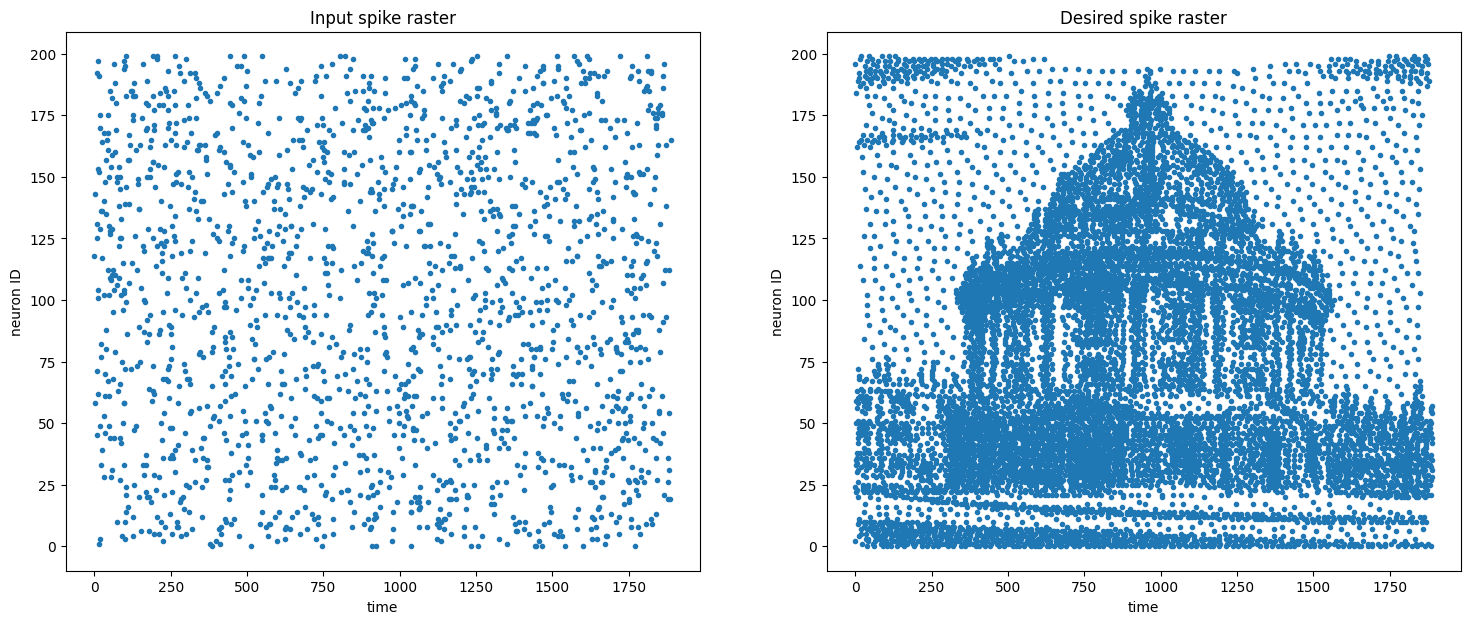

In [13]:
# showTD animation does not work in jupyter session
# snn.io.showTD(snn.io.spikeArrayToEvent(  input.reshape((1, Nin , -1)).cpu().data.numpy()))
# snn.io.showTD(snn.io.spikeArrayToEvent(desired.reshape((1, Nout, -1)).cpu().data.numpy()))
plt.figure(figsize=(18, 7))
plt.subplot(1, 2, 1)
plt.plot(inTD.t, inTD.x, '.')
plt.title('Input spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')

plt.subplot(1, 2, 2)
plt.plot(desTD.t, desTD.x, '.')
plt.title('Desired spike raster')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.show()


# Run the network
* Run the network for 10000 epochs
* `bestNetwork` is stored for inferencing later

In [14]:
import copy

In [15]:
losslog = list()

for epoch in range(10000):
    output = net.forward(input)

    loss = error.spikeTime(output, desired)

    if epoch%500 == 0:  print('loss in epoch', epoch, ':', loss.cpu().data.numpy())
    losslog.append(loss.cpu().data.numpy())

    if epoch==0:
        minLoss = loss
        bestNet = copy.deepcopy(net)
    else:
        if loss < minLoss:
            minLoss = loss
            bestNet = copy.deepcopy(net)

    if loss < 1e-5:	break

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

loss in epoch 0 : 12665936000.0


/usr/local/lib/python3.10/dist-packages/slayerSNN-0.0.0-py3.10.egg/slayerSNN/optimizer.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


loss in epoch 500 : 2066574200.0
loss in epoch 1000 : 1664524800.0
loss in epoch 1500 : 1472724100.0
loss in epoch 2000 : 1340721500.0
loss in epoch 2500 : 1269758000.0
loss in epoch 3000 : 1172649000.0
loss in epoch 3500 : 1129135400.0
loss in epoch 4000 : 1087471100.0
loss in epoch 4500 : 1073922700.0
loss in epoch 5000 : 1032656100.0
loss in epoch 5500 : 961382000.0
loss in epoch 6000 : 1027836800.0
loss in epoch 6500 : 958712450.0
loss in epoch 7000 : 940107000.0
loss in epoch 7500 : 902690600.0
loss in epoch 8000 : 894825500.0
loss in epoch 8500 : 868688600.0
loss in epoch 9000 : 839477950.0
loss in epoch 9500 : 839100540.0


## Inference using the best network

In [16]:
output = bestNet.forward(input)

## Plot the Results

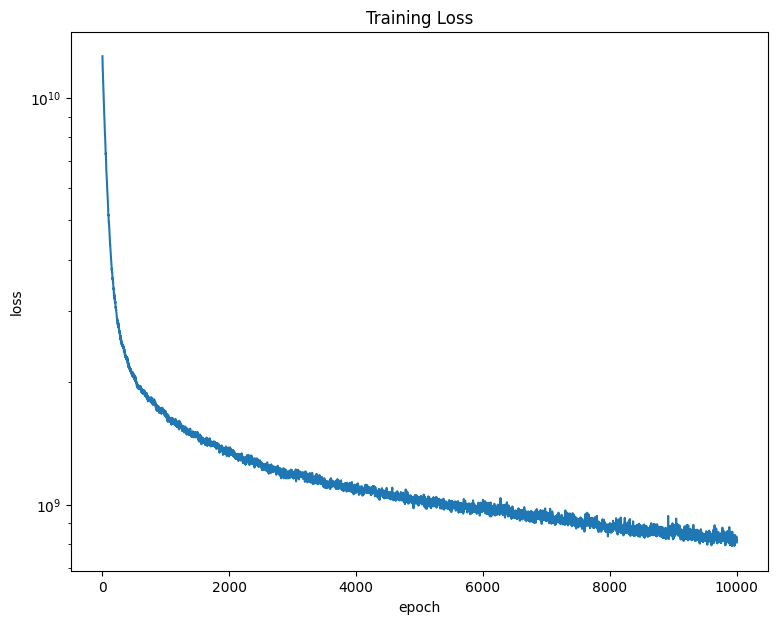

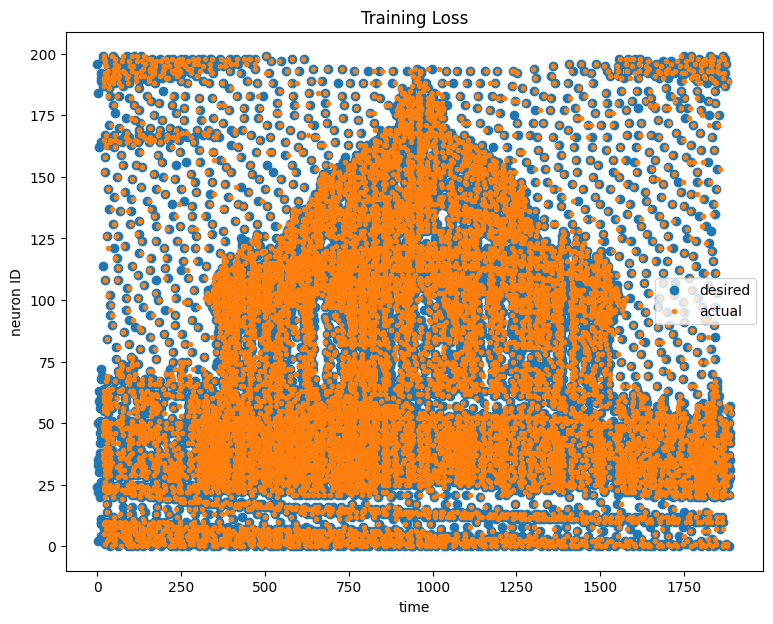

In [17]:
plt.figure(1, figsize=(9, 7))
plt.semilogy(losslog)
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure(2, figsize=(9, 7))
inpAER = np.argwhere(input.reshape((Nin, Ns)).cpu().data.numpy() > 0)
desAER = np.argwhere(desired.reshape((Nout, Ns)).cpu().data.numpy() > 0)
outAER = np.argwhere(output.reshape((Nout, Ns)).cpu().data.numpy() > 0)
plt.plot(desAER[:, 1], desAER[:, 0], 'o', label='desired')
plt.plot(outAER[:, 1], outAER[:, 0], '.', label='actual')
plt.title('Training Loss')
plt.xlabel('time')
plt.ylabel('neuron ID')
plt.legend()

plt.show()

In [22]:
!mkdir 'Trained'

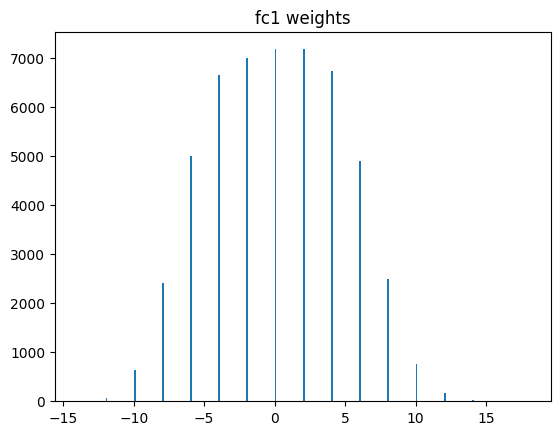

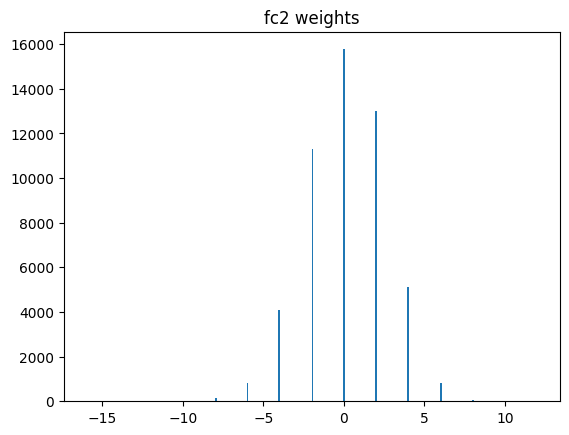

In [20]:
genLoihiParams(net)

np.savetxt('Trained/OxfordInp.txt', inpAER, fmt='%g')
np.savetxt('Trained/OxfordOut.txt', outAER, fmt='%g')
np.savetxt('Trained/OxfordDes.txt', desAER, fmt='%g')

with open('Trained/loss.txt', 'wt') as loss:
    loss.write('#%11s\r\n'%('Train'))
    for i in range(len(losslog)):
        loss.write('%12.6g\r\n'%(losslog[i]))
